# Reproducción del artículo en el conjuto de datos CVC-ClinicDB

El artículo que se utilizó fue: "DoubleU-Net: A deep Convolutional Neural Network for Medical Image Segmentation"


In [16]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil
import cv2

import json
from glob import glob
from sklearn.utils import shuffle
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

from tensorflow.keras.losses import binary_crossentropy

from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import *

from tqdm import tqdm
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

# **Utility functions**

Funciones para crear directorios, cargar o leer imagenes o parámetros de modelos preentrenados.

In [17]:
def create_dir(path):
    """ Create a directory. """
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

def read_data(impath, mskpath):
    """ Read the image and mask from the given path. """
    image = cv2.imread(impath, cv2.IMREAD_COLOR)
    mask = cv2.imread(mskpath, cv2.IMREAD_COLOR)
    return image, mask

def read_params():
    """ Reading the parameters from the JSON file."""
    with open("params.json", "r") as f:
        data = f.read()
        params = json.loads(data)
        return params

def load_data_(path):
    """ Loading the data from the given path. """
    images_path = os.path.join(path, "image/*")
    masks_path  = os.path.join(path, "mask/*")

    images = glob(images_path)
    masks  = glob(masks_path)

    return images, masks

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_model_weight(path):
    with ObjectScope({
        'dice_loss': dice_loss,
        'dice_coef': dice_coef,
        'bce_dice_loss': bce_dice_loss,
        'focal_loss': focal_loss,
        'iou': iou
        }):
        model = load_model(path)
    return model


# **Data handling** (data.py)

Instalar las transformaciones que utiliza el artículo sobre las imagenes de entrenamiento.

In [10]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-dmvpffne
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-dmvpffne
  Resolved https://github.com/albumentations-team/albumentations to commit b7877b7dcae4d0f7534f2f4d8708b381ca0800e6
  Preparing metadata (setup.py) ... done


In [11]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,
    CenterCrop,
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion,
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,
    RandomGamma,
    HueSaturationValue,
    RGBShift,
    RandomBrightness,
    RandomContrast,
    MotionBlur,
    MedianBlur,
    GaussianBlur,
    GaussNoise,
    ChannelShuffle,
    CoarseDropout
)

In [18]:
def augment_data(images, masks, save_path, augment=True):
    """ Performing data augmentation. """
#     crop_size = (288-32, 384-32)
#     size = (384,288)

    crop_size = (192-32, 256-32)
    size = (256, 192)

    for image, mask in tqdm(zip(images, masks), total=len(images)):
        # Extracting just the name of the image from its path,
        # even excluding the file extension
        image_name = image.split("/")[-1].split(".")[0]
        mask_name = mask.split("/")[-1].split(".")[0]

        # retrieving an image and a mask from the given paths 'image' and 'mask'
        x, y = read_data(image, mask)
        try:
            h, w, c = x.shape
        except Exception as e:
            image = image[:-1]
            x, y = read_data(image, mask)
            h, w, c = x.shape
    
        if augment == True:
            
            ## Center Crop
            aug = CenterCrop(p=1, height=crop_size[0], width=crop_size[1])
            augmented = aug(image=x, mask=y)
            x1 = augmented['image']
            y1 = augmented['mask']

            ## Crop
            x_min = 0
            y_min = 0
            x_max = x_min + size[0]
            y_max = y_min + size[1]

            aug = Crop(p=1, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
            augmented = aug(image=x, mask=y)
            x2 = augmented['image']
            y2 = augmented['mask']

            ## Random Rotate 90 degree
            aug = RandomRotate90(p=1)
            augmented = aug(image=x, mask=y)
            x3 = augmented['image']
            y3 = augmented['mask']

            ## Transpose
            aug = Transpose(p=1)
            augmented = aug(image=x, mask=y)
            x4 = augmented['image']
            y4 = augmented['mask']

            ## ElasticTransform
            aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
            augmented = aug(image=x, mask=y)
            x5 = augmented['image']
            y5 = augmented['mask']

            ## Grid Distortion
            aug = GridDistortion(p=1)
            augmented = aug(image=x, mask=y)
            x6 = augmented['image']
            y6 = augmented['mask']

            ## Optical Distortion
            aug = OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
            augmented = aug(image=x, mask=y)
            x7 = augmented['image']
            y7 = augmented['mask']

            ## Vertical Flip
            aug = VerticalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x8 = augmented['image']
            y8 = augmented['mask']

            ## Horizontal Flip
            aug = HorizontalFlip(p=1)
            augmented = aug(image=x, mask=y)
            x9 = augmented['image']
            y9 = augmented['mask']

            ## Grayscale
            x10 = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
            y10 = y

            ## Grayscale Vertical Flip
            aug = VerticalFlip(p=1)
            augmented = aug(image=x10, mask=y10)
            x11 = augmented['image']
            y11 = augmented['mask']

            ## Grayscale Horizontal Flip
            aug = HorizontalFlip(p=1)
            augmented = aug(image=x10, mask=y10)
            x12 = augmented['image']
            y12 = augmented['mask']

            ## Grayscale Center Crop
            aug = CenterCrop(p=1, height=crop_size[0], width=crop_size[1])
            augmented = aug(image=x10, mask=y10)
            x13 = augmented['image']
            y13 = augmented['mask']

            ##
            aug = RandomBrightnessContrast(p=1)
            augmented = aug(image=x, mask=y)
            x14 = augmented['image']
            y14 = augmented['mask']

            aug = RandomGamma(p=1)
            augmented = aug(image=x, mask=y)
            x15 = augmented['image']
            y15 = augmented['mask']

            aug = HueSaturationValue(p=1)
            augmented = aug(image=x, mask=y)
            x16 = augmented['image']
            y16 = augmented['mask']

            aug = RGBShift(p=1)
            augmented = aug(image=x, mask=y)
            x17 = augmented['image']
            y17 = augmented['mask']

            aug = RandomBrightness(p=1)
            augmented = aug(image=x, mask=y)
            x18 = augmented['image']
            y18 = augmented['mask']

            aug = RandomContrast(p=1)
            augmented = aug(image=x, mask=y)
            x19 = augmented['image']
            y19 = augmented['mask']

            aug = MotionBlur(p=1, blur_limit=7)
            augmented = aug(image=x, mask=y)
            x20 = augmented['image']
            y20 = augmented['mask']

            aug = MedianBlur(p=1, blur_limit=9)
            augmented = aug(image=x, mask=y)
            x21 = augmented['image']
            y21 = augmented['mask']

            aug = GaussianBlur(p=1, blur_limit=9)
            augmented = aug(image=x, mask=y)
            x22 = augmented['image']
            y22 = augmented['mask']

            aug = GaussNoise(p=1)
            augmented = aug(image=x, mask=y)
            x23 = augmented['image']
            y23 = augmented['mask']

            aug = ChannelShuffle(p=1)
            augmented = aug(image=x, mask=y)
            x24 = augmented['image']
            y24 = augmented['mask']

            aug = CoarseDropout(p=1, max_holes=8, max_height=32, max_width=32)
            augmented = aug(image=x, mask=y)
            x25 = augmented['image']
            y25 = augmented['mask']

            images = [
                x, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10,
                x11, x12, x13, x14, x15, x16, x17, x18, x19, x20,
                x21, x22, x23, x24, x25
            ]
            masks  = [
                y, y1, y2, y3, y4, y5, y6, y7, y8, y9, y10,
                y11, y12, y13, y14, y15, y16, y17, y18, y19, y20,
                y21, y22, y23, y24, y25
            ]

        else:
            images = [x]
            masks  = [y]

        idx = 0
        for i, m in zip(images, masks):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{image_name}_{idx}.jpg"
            tmp_mask_name  = f"{mask_name}_{idx}.jpg"

            image_path = os.path.join(save_path, "image/", tmp_image_name)
            mask_path  = os.path.join(save_path, "mask/", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1

def load_data(path, split=0.1):
    """ Load all the data and then split them into train and valid dataset. """
    
    img_path = glob(os.path.join(path, "Original/*"))
    msk_path = glob(os.path.join(path, "Ground Truth/*"))

    img_path.sort()
    msk_path.sort()

    len_ids = len(img_path)
    train_size = int((80/100)*len_ids)
    valid_size = int((10/100)*len_ids)		## Here 10 is the percent of images used for validation
    test_size = int((10/100)*len_ids)		## Here 10 is the percent of images used for testing

    train_x, test_x = train_test_split(img_path, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(msk_path, test_size=test_size, random_state=42)

    train_x, valid_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, valid_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


# Dataset CVC-ClinicDB

Esta es una base de datos ampleamente usada para la segmentación de polipos, la cual consiste de 612 imagenes de 284x288. La base de datos contiene las imagenes de colonoscopía en RGB y las máscaras de segmentación.

**Split images into training, validation and test**

Se utilizan 80% de la base de datos para entrenamiento, 10% para validación y 10% para prueba. En este caso, se redujo el número de imágenes que se utilizan para entrenamiento debido al costo computacional. 


In [7]:
np.random.seed(42)
path = "/kaggle/input/d/balraj98/cvcclinicdb/PNG"
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path, split=0.1)

In [13]:

create_dir("new_data/train/image/")
create_dir("new_data/train/mask/")
create_dir("new_data/valid/image/")
create_dir("new_data/valid/mask/")
create_dir("new_data/test/image/")
create_dir("new_data/test/mask/")

augment_data(train_x[:200], train_y[:200], "new_data/train/", augment=True)
augment_data(valid_x, valid_y, "new_data/valid/", augment=False)
augment_data(test_x, test_y, "new_data/test/", augment=False)

  0%|          | 0/200 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1151: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1177: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/blur/transforms.py:185: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  "blur_limit and sigma_limit minimum value can not be both equal to 0. "
100%|██████████| 61/61 [00:00<00:00, 73.75it/s]


# Dataset visualization

In [14]:
def plot_dataset(path,nrows=5, ncols=10,figsize=(30, 8)):
    img_set, msk_set = load_data_(path)
    fig = plt.figure(figsize=figsize)
    for i in range(1,nrows*ncols):
        img, mask = read_data(img_set[i], msk_set[i])
        fig.add_subplot(nrows,ncols,i)  
        plt.imshow(cv2.cvtColor(np.concatenate((img,mask),axis=1), cv2.COLOR_BGR2RGB))
        plt.title(img_set[i].split('/')[-1])
    plt.show()

## Training dataset

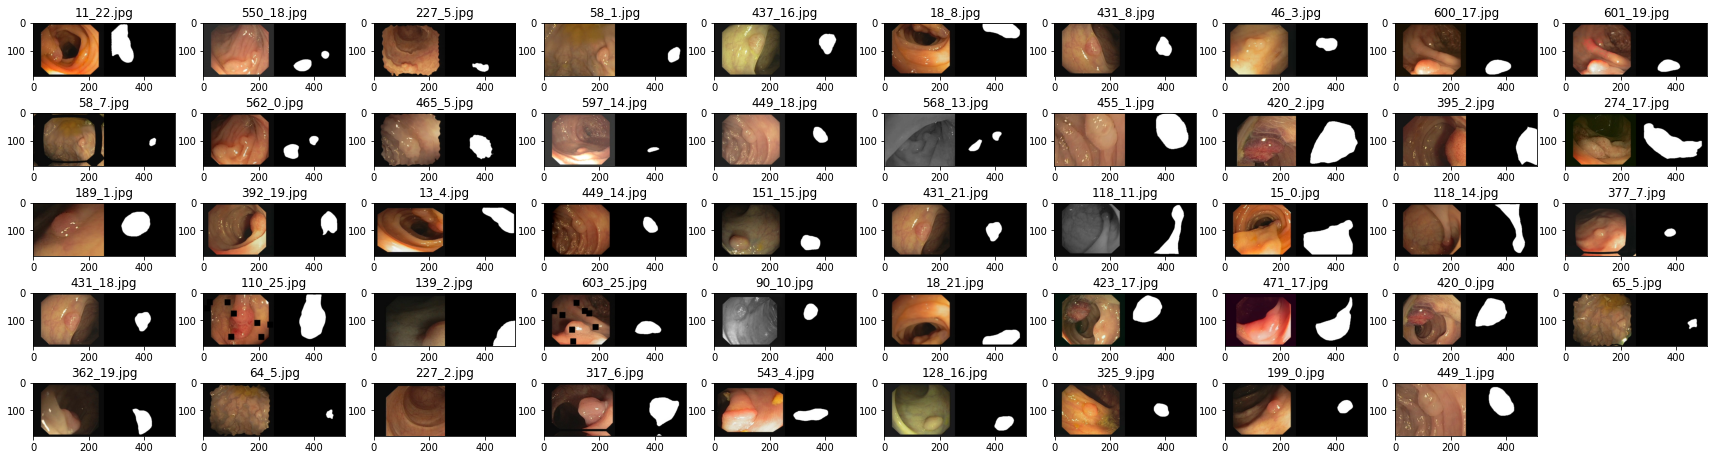

In [60]:
path = '/kaggle/working/new_data/train'
plot_dataset(path)

## Validation dataset

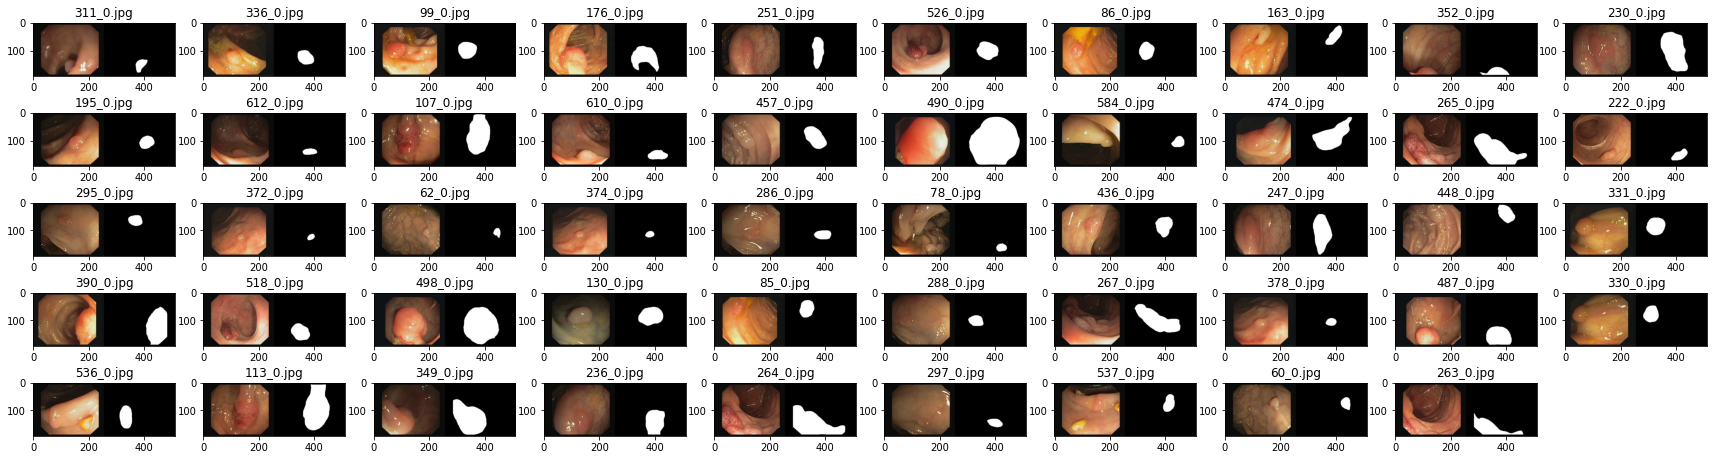

In [61]:
path = '/kaggle/working/new_data/valid'
plot_dataset(path)

## Test dataset

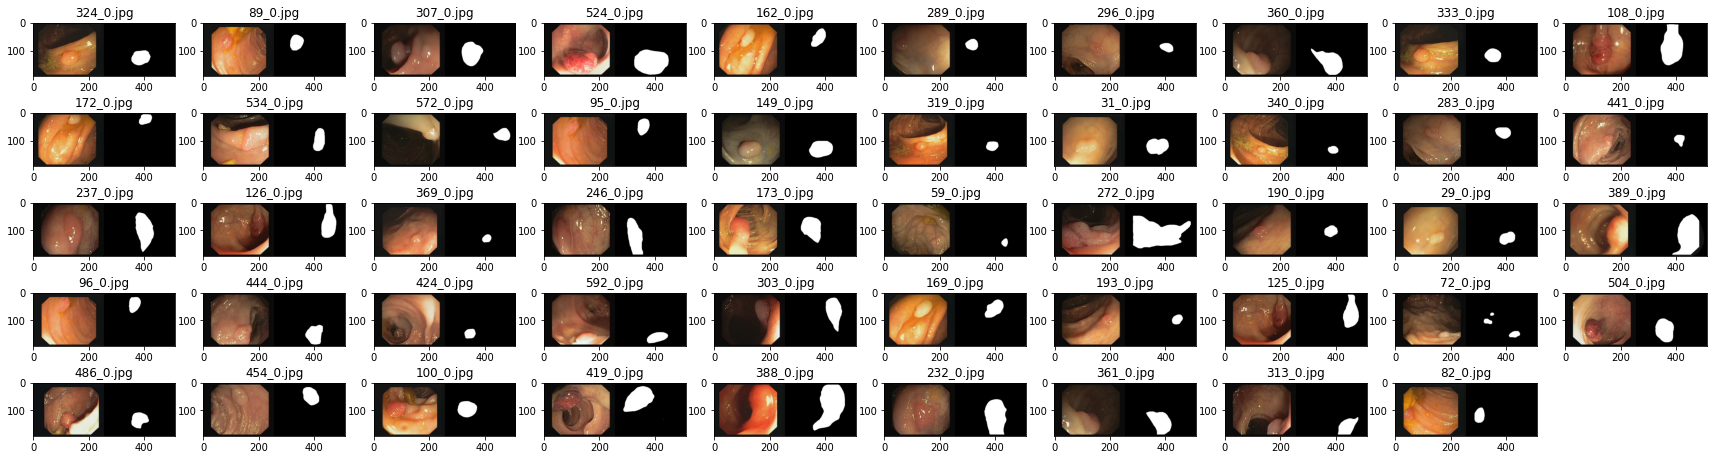

In [63]:
path = '/kaggle/working/new_data/test'
plot_dataset(path)

# **Model**

![](https://raw.githubusercontent.com/DebeshJha/2020-CBMS-DoubleU-Net/master/img/DoubleU-Net.png)

In [18]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs)
    return model

# **Metrics (metrics.py)**

In [20]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

def load_model_weight(path):
    with CustomObjectScope({
        'dice_loss': dice_loss,
        'dice_coef': dice_coef,
        'bce_dice_loss': bce_dice_loss,
        'focal_loss': focal_loss,
        'iou': iou
        }):
        model = load_model(path)
    return model

# **Auxiliary function for training**
Aquí la función parse_data dimimuye la resolución de las imagenes para reducir el costo computacional.

In [21]:
def read_image(x):
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)
    return image

def read_mask(y):
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    mask = mask.astype(np.float32)
    mask = mask/255.0
    mask = np.expand_dims(mask, axis=-1)
    return mask

def mask_to_3d(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

def parse(y_pred):
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = y_pred[..., -1]
    y_pred = y_pred.astype(np.float32)
    y_pred = np.expand_dims(y_pred, axis=-1)
    return y_pred

def evaluate_normal(model, x_data, y_data):
    THRESHOLD = 0.5
    total = []
    for i, (x, y) in tqdm(enumerate(zip(x_data, y_data)), total=len(x_data)):
        x = read_image(x)
        y = read_mask(y)
        _, h, w, _ = x.shape

        y_pred1 = parse(model.predict(x)[0][..., -2])
        y_pred2 = parse(model.predict(x)[0][..., -1])
        
        line = np.ones((h, 10, 3)) * 255.0
        
        all_images = [
            x[0] * 255.0, line,
            mask_to_3d(y) * 255.0, line,
            mask_to_3d(y_pred1) * 255.0, line,
            mask_to_3d(y_pred2) * 255.0
        ]
        mask = np.concatenate(all_images, axis=1)

        cv2.imwrite(f"results/{i}.png", mask)

def features_labels(featFiles, labFiles):
    features = []
    labels = []
    for img, mask in zip(featFiles, labFiles):
        x,y = parse_data(img, mask)
        features.append(x)
        labels.append(y)
    features = tf.constant(features)
    labels = tf.constant(labels)
    return features, labels

def parse_data(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        y = np.concatenate([y, y], axis=-1)
        return x, y
    x, y = _parse(x, y)
    x=x.reshape([192, 256, 3])
    y=y.reshape([192, 256, 2])
    return x, y

def tf_dataset(featFiles, labFiles, batch=16):
#     features, labels = features_labels(featFiles, labFiles)
    dataset = tf.data.Dataset.from_tensor_slices((features_labels(featFiles, labFiles)))
    dataset = dataset.shuffle(buffer_size=32)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    return dataset

# Training

In [10]:
np.random.seed(42)
tf.random.set_seed(42)
create_dir("files")


model_path = "files/model.h5"
batch_size = 16
epochs = 100
lr = 1e-5
shape = (192, 256, 3)


train_path = "/kaggle/input/cvcclinicdb/new_data/train"
valid_path = "/kaggle/input/cvcclinicdb/new_data/valid"

## Training
train_x = sorted(glob(os.path.join(train_path, "image", "*.jpg")))
train_y = sorted(glob(os.path.join(train_path, "mask", "*.jpg")))

## Shuffling
train_x, train_y = shuffling(train_x, train_y)

## Validation
valid_x = sorted(glob(os.path.join(valid_path, "image", "*.jpg")))
valid_y = sorted(glob(os.path.join(valid_path, "mask", "*.jpg")))

model = build_model(shape)
metrics = [
    dice_coef,
    iou,
    Recall(),
    Precision()
]

train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

model.compile(loss=binary_crossentropy, optimizer=Nadam(lr), metrics=metrics)

callbacks = [
    ModelCheckpoint(model_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20),
    CSVLogger("files/data.csv"),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]

train_steps = (len(train_x)//batch_size)
valid_steps = (len(valid_x)//batch_size)

if len(train_x) % batch_size != 0:
    train_steps += 1

if len(valid_x) % batch_size != 0:
    valid_steps += 1

NameError: name 'creat' is not defined

In [29]:
model.compile(loss=binary_crossentropy, optimizer=Nadam(lr), metrics=metrics)

In [30]:
model.fit(train_dataset,
        epochs=epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks,
        shuffle=False)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-12-03 06:41:48.022631: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3067084800 exceeds 10% of free system memory.


Epoch 1/100


2022-12-03 06:42:06.264368: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-03 06:42:12.196521: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-12-03 06:42:28.541784: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-12-03 06:42:28.541912: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.58GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  1/325 [..............................] - ETA: 3:34:42 - loss: 0.7738 - dice_coef: 0.1524 - iou: 0.0825 - recall: 0.6332 - precision: 0.0998

2022-12-03 06:42:34.223138: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-03 06:42:34.223189: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/325 [..............................] - ETA: 11:54 - loss: 0.7788 - dice_coef: 0.1617 - iou: 0.0880 - recall: 0.5859 - precision: 0.1032  

2022-12-03 06:42:35.936242: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-03 06:42:35.941443: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-03 06:42:36.242614: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 5480 callback api events and 5474 activity events. 
2022-12-03 06:42:36.434504: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-03 06:42:36.686108: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_12_03_06_42_36

2022-12-03 06:42:36.787739: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_12_03_06_42_36/564501ea41f3.trace.json.gz
2022-12-03 06:42:36.992271: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/pl

325/325 [==============================] - 327s 888ms/step - loss: 0.6016 - dice_coef: 0.2390 - iou: 0.1370 - recall: 0.7368 - precision: 0.2459 - val_loss: 0.5428 - val_dice_coef: 0.1842 - val_iou: 0.1015 - val_recall: 0.3694 - val_precision: 0.2529
Epoch 2/100
325/325 [==============================] - 286s 880ms/step - loss: 0.4122 - dice_coef: 0.3459 - iou: 0.2101 - recall: 0.7906 - precision: 0.8194 - val_loss: 0.3810 - val_dice_coef: 0.3306 - val_iou: 0.1997 - val_recall: 0.7720 - val_precision: 0.8860
Epoch 3/100
325/325 [==============================] - 286s 881ms/step - loss: 0.3612 - dice_coef: 0.3806 - iou: 0.2362 - recall: 0.8283 - precision: 0.9222 - val_loss: 0.3605 - val_dice_coef: 0.3574 - val_iou: 0.2184 - val_recall: 0.8158 - val_precision: 0.9121
Epoch 4/100
325/325 [==============================] - 286s 881ms/step - loss: 0.3340 - dice_coef: 0.4022 - iou: 0.2530 - recall: 0.8512 - precision: 0.9469 - val_loss: 0.3440 - val_dice_coef: 0.3754 - val_iou: 0.2312 - val

In [ ]:
shutil.make_archive("files", 'zip', "/kaggle/working/files")

# Metrics

In [4]:
metrics_trn = pd.read_csv('/kaggle/input/trainingresultsdeeplearningfinalproject/Training results/DobleUNet/training_results/data.csv')  
metrics_trn = metrics_trn.set_index('epoch')
metrics_trn.head(10)

,dice_coef,iou,loss,lr,precision,recall,val_dice_coef,val_iou,val_loss,val_precision,val_recall
epoch,,,,,,,,,,,
0,0.239009,0.137012,0.601586,0.00001,0.245852,0.736818,0.184205,0.101518,0.542761,0.252877,0.369393
1,0.345876,0.210095,0.412211,0.00001,0.819405,0.790649,0.330582,0.199740,0.381017,0.885982,0.772046
2,0.380649,0.236213,0.361217,0.00001,0.922222,0.828287,0.357449,0.218354,0.360491,0.912126,0.815764
3,0.402207,0.252968,0.334010,0.00001,0.946941,0.851240,0.375418,0.231204,0.343972,0.900892,0.807132
4,0.417944,0.265485,0.313994,0.00001,0.957245,0.860480,0.386980,0.241386,0.326837,0.896646,0.866006
5,0.431347,0.276408,0.297216,0.00001,0.962908,0.869446,0.399105,0.249518,0.320200,0.904775,0.850772
6,0.444156,0.286997,0.282172,0.00001,0.967489,0.875292,0.396988,0.247986,0.310296,0.913249,0.798227
7,0.457800,0.298353,0.266732,0.00001,0.968929,0.877476,0.411352,0.261318,0.290615,0.921281,0.817685
8,0.469985,0.308835,0.253344,0.00001,0.972287,0.880496,0.428934,0.273811,0.282385,0.893125,0.863611


Text(0.5, 1.0, 'Precisión')

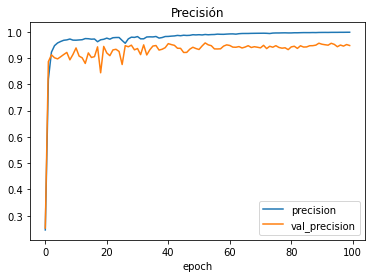

In [11]:
lines = metrics_trn[["precision","val_precision"]].plot.line()
plt.title("Precisión")
# plt.leyend([])

Text(0.5, 1.0, 'Recall')

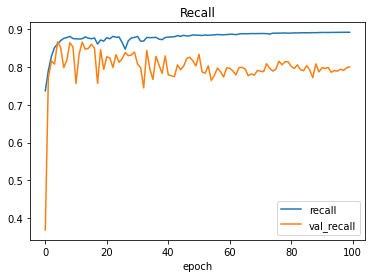

In [13]:
lines = metrics_trn[["recall","val_recall"]].plot.line()
plt.title("Recall")

# Predicciones

In [1]:
np.random.seed(42)
tf.random.set_seed(42)
create_dir("results/")
m = load_model_weight("/kaggle/input/trainingresultsdeeplearningfinalproject/Training results/DobleUNet/files (2)/cvc-model.h5")
evaluate_normal(m, test_x, test_y)

NameError: name 'np' is not defined

In [ ]:
shutil.make_archive("results", 'zip', "/kaggle/working/results")

In [ ]:
results = "/kaggle/working/results"
test = sorted(glob(results+'/*'))
x = read_image(test[15])
plt.imshow(x,cmap='viridis',vmin=x.min(), vmax=x.max())
plt.show()